## Exploratory Data Analysis

#### 1.1. Imports

In [35]:
!pip install matplotlib
!pip install seaborn
%pip install scipy

python(94417) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(94424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(94427) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, scipy.stats as st
from scipy.stats import pointbiserialr

#### 1.2. Reading the data

In [37]:
mlog_stats = pd.read_csv('../data/mlog_stats_10000.csv')
impression_data = pd.read_csv('../data/impression_data_10000.csv')
mlog_demographics = pd.read_csv('../data/mlog_demographics_10000.csv')
user_demographics = pd.read_csv('../data/user_demographics_10000.csv')

In [ ]:
print(mlog_stats.head())
print(mlog_demographics.head())
print(impression_data.head())
print(user_demographics.head())

           mlogId  dt  userImprssionCount  userClickCount  userLikeCount  \
0  KCNCLCICKCHCLC  26                7907              71              1   
1  KCOCNCHCGCHCIC  30                   1               0              0   
2  NCKCMCKCNCNCOC  11                 169              15              1   
3  NCJCOCJCLCGCJC  14                 324              27              2   
4  NCGCOCKCOCOCKC  17                 154              10              2   

   userCommentCount  userShareCount  userViewCommentCount  \
0                 0               0                     3   
1                 0               0                     0   
2                 0               0                     0   
3                 1               0                     7   
4                 0               0                     4   

   userIntoPersonalHomepageCount  userFollowCreatorCount  
0                              0                       0  
1                              0                       0  

#### 2. Statistics

In [39]:
imp = impression_data.copy()
ud = user_demographics.copy()

### 2.1. Distributions

### 2.1.1 Share of impressions in the dataset
First, lets get a quick sense of how often non-click interactions occur on impressions: likes, view comment, shares, comments. This gives us a baseline for sparsity and helps decide which targets/features are viable for modeling.

In [61]:
# Simple statistics
print("\nBasic statistics (impression_data):")
cols = ["isLike", "isViewComment", "isShare", "isComment", "isClick"]
eng_stats = {}
for c in cols:
    if c in imp.columns:
        eng_stats[c] = {
            "Total": int(imp[c].sum()),
            "Share of total impressions": round(imp[c].mean()*100, 2),
        }

eng_df = pd.DataFrame(eng_stats).T
print(eng_df)


Basic statistics (impression_data):
               Total  Share of total impressions
isLike          40.0                        0.40
isViewComment  101.0                        1.01
isShare          1.0                        0.01
isComment        3.0                        0.03
isClick        471.0                        4.71


#### Interpretation
Shares and comments are vanishingly rare at the impression level (≤0.03%). Likes are also rare (0.40%). Only “view comment” reaches ~1% and "isClick" over 4%.

#### Visualization

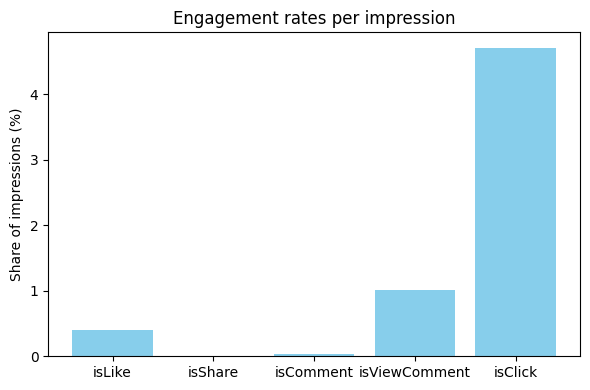

In [62]:
eng_cols = ["isLike", "isShare", "isComment", "isViewComment", "isClick"]

eng_rates = {}
for c in eng_cols:
    if c in imp.columns:
        eng_rates[c] = imp[c].mean() * 100  # percentage

# Engagement rates per impression
plt.figure(figsize=(6,4))
plt.bar(eng_rates.keys(), eng_rates.values(), color="skyblue")
plt.ylabel("Share of impressions (%)")
plt.title("Engagement rates per impression")
plt.tight_layout()
plt.show()

#### Implications

Clicks are the main interaction we can observe at scale. Actions that require intent after the click (like/share/comment) are orders of magnitude rarer. Predicting likes/shares/comments per impression will be unstable (extreme class imbalance).

### 2.1.2 Age and Gender Distribution

We visualize the user age and gender distribution (one row per user) to understand demographic coverage and to judge whether age- or gender-related effects will be identifiable. A concentrated age/gender mass implies that age will explain only a small share of variance; sparse tails require careful reporting (or pooling) to avoid noisy conclusions.

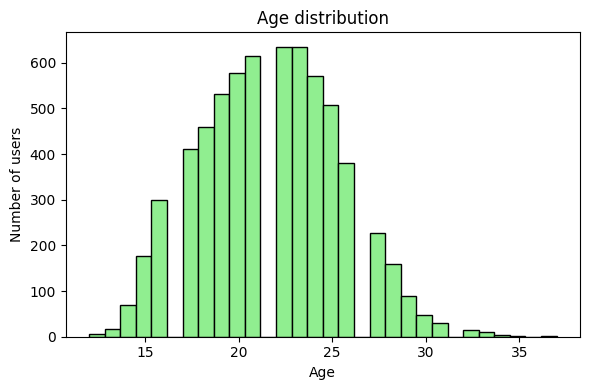

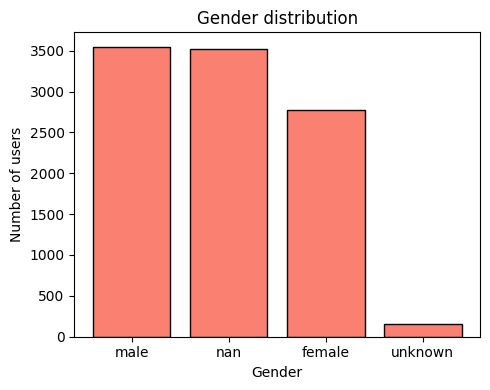

In [42]:
# Age distribution
if "age" in ud.columns:
    plt.figure(figsize=(6,4))
    plt.hist(ud["age"].dropna(), bins=30, color="lightgreen", edgecolor="black")
    plt.xlabel("Age")
    plt.ylabel("Number of users")
    plt.title("Age distribution")
    plt.tight_layout()
    plt.show()

# Gender distribution
if "gender" in ud.columns:
    gender_counts = ud["gender"].value_counts(dropna=False)
    plt.figure(figsize=(5,4))
    plt.bar(gender_counts.index.astype(str), gender_counts.values, color="salmon", edgecolor="black")
    plt.xlabel("Gender")
    plt.ylabel("Number of users")
    plt.title("Gender distribution")
    plt.tight_layout()
    plt.show()

#### Implications

The population is predominantly 18–25 with a long but thin right tail above 30. Skewness is modest but because the 30+ cohort is small, age effects beyond 25 are underpowered.

For gender the sample is male-skewed. A large “nan/missing” bucket exists (comparable in size to “male”).
The bucket “unknown” is tiny.

### 2.1.3 Per-user enagagement profile

The next step is to collapse impression rows into one row per user so we can study how activity and engagement vary across the population.

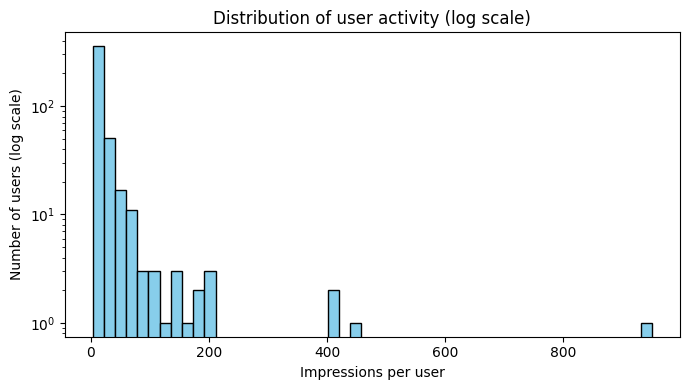

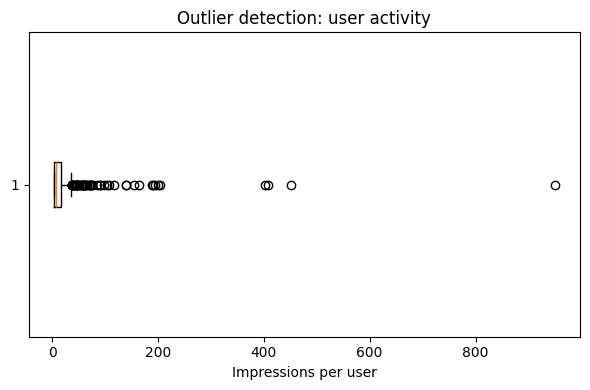


Top 10 most active users (by impressions):
                   userId  impressions  clicks  likes  shares  comments  \
231  PCKCKCHCOCKCPCICNCLC          950      96      0       0         0   
359  PCLCLCGCPCICPCGCOCJC          451      30      3       0         0   
219  PCKCJCKCNCNCICLCKCIC          408      33      0       0         0   
447  PCNCHCLCGCKCLCKCKCLC          403      21      0       0         0   
67   PCICKCJCJCHCICPCLCPC          203       0      0       0         0   
261  PCKCNCGCOCNCPCOCOCHC          200       4      0       0         0   
100  PCICNCMCKCJCKCOCHCJC          195      10      4       1         0   
123  PCICPCPCMCJCMCPCPCNC          190      10      0       0         0   
446  PCNCHCKCLCOCJCICOCOC          188      15     13       0         3   
143  PCJCOCPCICMCICNCNCLC          164       0      0       0         0   

          ctr  like_rate  share_rate  comment_rate  
231  0.101053   0.000000    0.000000      0.000000  
359  0.066519   0.006652

In [43]:
# Per-user aggregation
user_agg = imp.groupby("userId").agg(
    impressions = ("mlogId","count"),
    clicks      = ("isClick","sum"),
    likes       = ("isLike","sum"),
    shares      = ("isShare","sum"),
    comments    = ("isComment","sum")
).reset_index()

# Rates (protect against division by zero)
user_agg["ctr"]        = user_agg["clicks"] / user_agg["impressions"].replace(0, np.nan)
user_agg["like_rate"]  = user_agg["likes"]  / user_agg["impressions"].replace(0, np.nan)
user_agg["share_rate"] = user_agg["shares"] / user_agg["impressions"].replace(0, np.nan)
user_agg["comment_rate"]= user_agg["comments"]/ user_agg["impressions"].replace(0, np.nan)

#Impressions per user distribution
plt.figure(figsize=(7,4))
plt.hist(user_agg["impressions"], bins=50, log=True, color="skyblue", edgecolor="black")
plt.xlabel("Impressions per user")
plt.ylabel("Number of users (log scale)")
plt.title("Distribution of user activity (log scale)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot(user_agg["impressions"], vert=False)
plt.xlabel("Impressions per user")
plt.title("Outlier detection: user activity")
plt.tight_layout()
plt.show()

# Top 10 most active users
print("\nTop 10 most active users (by impressions):")
print(user_agg.sort_values("impressions", ascending=False).head(10))

#### Implications

The heavy-tailed histogram (on log scale) and the long right tail in the boxplot mean a small fraction of users see a lot of impressions.

We can see that top users are not uniformly “engaged.” High volume often coexists with average or low CTR, which suggests passive consumption patterns. Higher-intent actions are rare even at the top: most have 0 likes/shares/comments.
A few top users exhibit above-average like/comment activity.

### 2.2. Missing Data
### 2.2.1. Column-level

In [63]:
#Loading the merged dataset
df = pd.read_csv("../data/imp_sample_100k_merged.csv")

to_num = lambda s: pd.to_numeric(s, errors='coerce')

# obviously invalid values as missing 
special_nan = {
    'age': lambda s: s.where((s>=10) & (s<=100)),            # age outside [10,100] -> NaN
    'mlogViewTime': lambda s: s.where(s>=0),                 # negative dwell -> NaN
}

df_chk = df.copy()
for col, fn in special_nan.items():
    if col in df_chk.columns:
        df_chk[col] = fn(to_num(df_chk[col]))

def missing_table(frame):
    out = []
    n = len(frame)
    for c in frame.columns:
        miss = frame[c].isna().mean()
        dtype = frame[c].dtype
        # “special zero” flag example for dwell time
        special_zero = np.nan
        if c == 'mlogViewTime':
            special_zero = (frame[c].fillna(0).eq(0).mean())  # share of zeros
        out.append([c, dtype, miss, special_zero])
    tab = pd.DataFrame(out, columns=['column','dtype','missing_rate','share_eq_zero'])
    return tab.sort_values('missing_rate', ascending=False)

miss_tab = missing_table(df_chk)
print(miss_tab.head(20).to_string(index=False))

            column   dtype  missing_rate  share_eq_zero
      mlogViewTime float64       0.95370        0.95475
               age float64       0.37263            NaN
            gender  object       0.37263            NaN
         contentId  object       0.17199            NaN
          province  object       0.00003            NaN
        user_level float64       0.00003            NaN
         followCnt float64       0.00003            NaN
registeredMonthCnt float64       0.00003            NaN
              type float64       0.00002            NaN
            talkId float64       0.00002            NaN
       publishTime float64       0.00002            NaN
         creatorId  object       0.00002            NaN
       creatorType float64       0.00002            NaN
     creator_level float64       0.00002            NaN
   impressPosition   int64       0.00000            NaN
                dt   int64       0.00000            NaN
            isLike   int64       0.00000        

#### Implications

- mlogViewTime → 95.37% missing, and 95.48% are zeros among non-NA.

➜ Interpretation: most impressions have no watch time recorded (true zeros) and many rows have NA (likely unlogged/unsupported). We will not treat zeros as missing; they mean “no watch.”

- age, gender → 37.3% missing each.

➜ Large non-random missingness; we will always keep a Missing/Unknown category (for gender) and add a missingness indicator for age when modeling.

- contentId → 17.2% missing.

➜ We will exclude this from content/creator analyses.

### 2.2.2. Row-level

Rows with >50% missing: 0.0 (share)


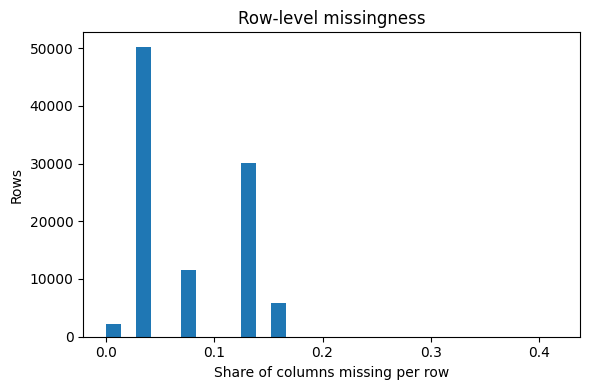

In [64]:
row_miss = df_chk.isna().mean(axis=1)
print("Rows with >50% missing:", (row_miss>0.5).mean(), "(share)")

# Quick histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(row_miss, bins=30)
plt.xlabel('Share of columns missing per row'); plt.ylabel('Rows')
plt.title('Row-level missingness'); plt.tight_layout(); plt.show()

#### Implications

Row-level missingness is low—no rows exceed 50% NA. Most rows are complete except for a small set of profile fields (age/gender) and dwell logging. This supports a column-wise handling strategy.

### 2.3. Relationships

The next step is to quantify linear relationships among numeric features at the impression level. We do this to flag near-duplicate variables (e.g., two timestamps) and multicollinearity risks for models.

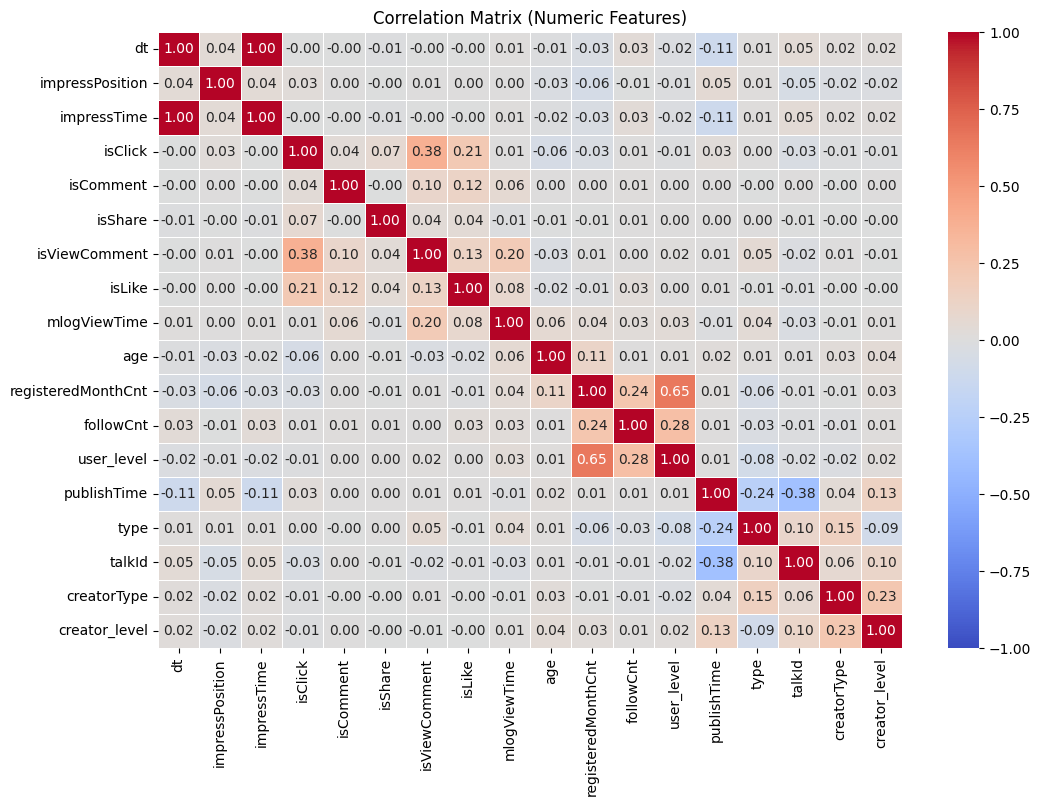

In [ ]:
df = pd.read_csv("../data/imp_sample_100k_merged.csv")

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=["number"])

# Compute correlation matrix
corr = numeric_df.corr()

# Display as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

#### Implications
##### Duplicates
- **dt ↔ impressTime ≈ 1.00**
→ They encode the same time information 
##### Strongest relationships
- **user_level ↔ registeredMonthCnt ≈ +0.65**

→ Users registered longer show substantially higher platform activity intensity.
- **followCnt ↔ user_level ≈ +0.28**

→ More follows co-move with higher activity intensity.
- **isClick ↔ isViewComment ≈ +0.38 and isClick ↔ isLike ≈ +0.21**

→ Post-click actions are most likely when a click happens (expected funnel behavior).
- **mlogViewTime ↔ isViewComment ≈ +0.20 (and small + with isLike)**

→ Longer watch time couples with deeper engagement.

### 3. User Activity
### 3.1. Distribution of User Activity
We want to understand how the platform’s activity intensity (0–10) is distributed across users. This informs whether activity is concentrated or broad, sensible cutoffs for “more active” cohorts, how much variance user_level can explain in downstream EDA.

In [ ]:
# --- Identify/alias user_level column (handles 'user_level' OR 'level_x') ---
UL_CANDIDATES = [c for c in ['user_level','level_x'] if c in df.columns]
if not UL_CANDIDATES:
    raise ValueError("No user_level column found. Expected 'user_level' or 'level_x'.")
UL_COL = UL_CANDIDATES[0]

# --- Basic coercions for fields we’ll use ---
to_num = lambda s: pd.to_numeric(s, errors='coerce')

df[UL_COL] = to_num(df[UL_COL])
if 'age' in df.columns: df['age'] = to_num(df['age'])
for c in ['isClick','isLike','isShare','isComment']:
    if c in df.columns: df[c] = to_num(df[c]).fillna(0).astype('int8')
if 'mlogViewTime' in df.columns:
    df['mlogViewTime'] = to_num(df['mlogViewTime'])

# Impression timestamp to datetime (optional but useful)
if 'impressTime' in df.columns:
    df['impress_ts'] = pd.to_datetime(to_num(df['impressTime']), unit='ms', errors='coerce')

# --- One row per user (stable attributes) ---
user_cols = ['userId', UL_COL, 'age', 'gender', 'province', 'registeredMonthCnt']
user_cols = [c for c in user_cols if c in df.columns]
users = (df[user_cols].drop_duplicates('userId').set_index('userId').rename(columns={UL_COL:'user_level'}))


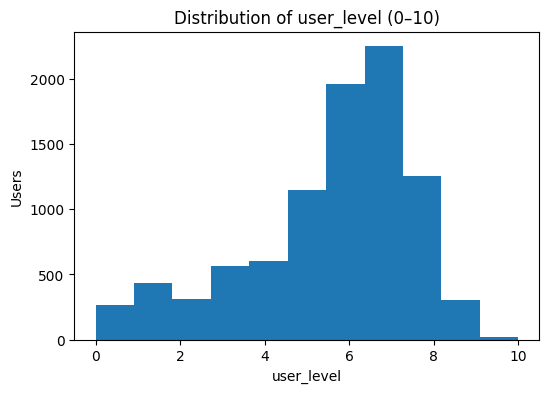

count    9095.00
mean        5.64
std         2.17
min         0.00
10%         2.00
25%         5.00
50%         6.00
75%         7.00
90%         8.00
max        10.00
Name: user_level, dtype: float64


In [52]:
# Histogram
fig = plt.figure(figsize=(6,4))
users['user_level'].dropna().plot(kind='hist', bins=11)
plt.title('Distribution of user_level (0–10)')
plt.xlabel('user_level'); plt.ylabel('Users')
plt.show()

# Summary stats 
print(users['user_level'].describe(percentiles=[.1,.25,.5,.75,.9]).round(2))


#### Implications

Most users cluster around medium activity (levels 5–8), with relatively few at the extremes and a mean of 5.64. Using bins {0–2, 3–4, 5–6, 7–10}, the medium and high groups together comprise the majority of the audience, while the very low group is small but important for churn risk.

### 3.2. User demographics and their activity

The next step is to explore whether user demographics are associate with their activity.

Users per age bin:
 age_bin
<18       946
18-24    3658
25-34    1282
35-44       3
45-54       0
55-64       0
65+         0
NaN      3207
Name: count, dtype: int64
Spearman(user_level, age) = 0.035 (p=8.07e-03)  [all users with age]

user_level by age_bin (stable bins only):
          count  mean  median
age_bin                     
<18        946  5.50     6.0
18-24     3658  5.65     6.0
25-34     1282  5.63     6.0

Kruskal–Wallis across stable age bins: H=13.17, p=1.38e-03


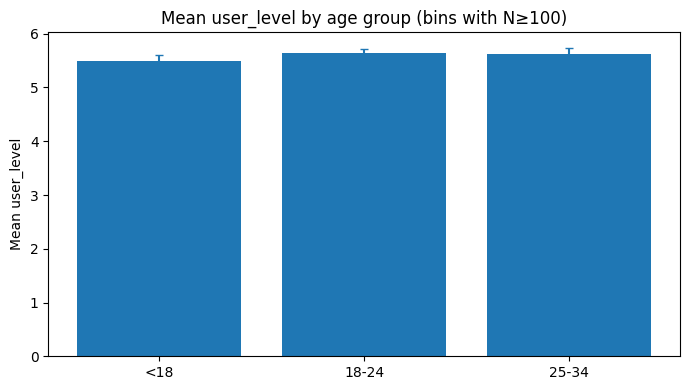

In [56]:
MIN_BIN_N = 100  # require at least this many users in a bin to include in tests/plots

# Assuming you already built `users` with one row per user and a numeric `user_level` + `age`
# users = df[['userId','user_level','age','gender','province']].drop_duplicates('userId').set_index('userId')
users = users.copy()

# 1) Define age bins and drop empty/sparse ones
bins   = [0,18,25,35,45,55,65,120]
labels = ['<18','18-24','25-34','35-44','45-54','55-64','65+']
users['age_bin'] = pd.cut(pd.to_numeric(users['age'], errors='coerce'),
                          bins=bins, labels=labels, right=False, include_lowest=True)

# Count per bin
bin_counts = users['age_bin'].value_counts(dropna=False)
print("Users per age bin:\n", bin_counts.sort_index())

# Keep only bins with enough data for stable stats
valid_bins = set(bin_counts[bin_counts >= MIN_BIN_N].index)
stable = users[users['age_bin'].isin(valid_bins)].dropna(subset=['user_level'])

# 2) Spearman (using raw ages, drop NaNs)
mask = users[['user_level','age']].notna().all(axis=1)
rho, p = st.spearmanr(users.loc[mask, 'user_level'], users.loc[mask, 'age'])
print(f"Spearman(user_level, age) = {rho:.3f} (p={p:.2e})  [all users with age]")

# 3) Group stats on stable bins only (observed=True avoids warnings)
lvl_by_age = (stable.groupby('age_bin', observed=True)['user_level']
                     .agg(count='size', mean='mean', median='median')
                     .round(2)
                     .sort_index())
print("\nuser_level by age_bin (stable bins only):\n", lvl_by_age)

# 4) Nonparametric test across stable bins
groups = [g['user_level'].dropna().values
          for _, g in stable.groupby('age_bin', observed=True)]
if len(groups) >= 2:
    H, pval = st.kruskal(*groups)
    print(f"\nKruskal–Wallis across stable age bins: H={H:.2f}, p={pval:.2e}")
else:
    print("\nNot enough stable bins for Kruskal–Wallis.")

# 5) Plot: mean user_level by age group with 95% CI (stable bins only)
means = lvl_by_age['mean']
ns    = lvl_by_age['count']
# Standard error and 95% CI assuming approx normality of means
stds  = (stable.groupby('age_bin', observed=True)['user_level'].std()).reindex(lvl_by_age.index)
ses   = stds / np.sqrt(ns)
ci95  = 1.96 * ses

fig = plt.figure(figsize=(7,4))
x = np.arange(len(means))
plt.bar(x, means.values)
plt.errorbar(x, means.values, yerr=ci95.values, fmt='none', capsize=3)
plt.xticks(x, lvl_by_age.index, rotation=0)
plt.ylabel('Mean user_level')
plt.title('Mean user_level by age group (bins with N≥{})'.format(MIN_BIN_N))
plt.tight_layout(); plt.show()



#### Implications

**Trend tests**

Spearman(user_level, age) = 0.035 (p = 8.07e-03).
Statistically significant with big N, but tiny in magnitude so a practically negligible trend.

Kruskal–Wallis across stable bins (<18, 18–24, 25–34): H = 13.17, p = 1.38e-03.
Some difference exists across bins, but the effect size is small.

**Conclusion**

We see that the practical effect is **minimal**. Age explains very little of user_level.
Missing ages are large (~1/3).
Older bins are empty. We cannot interpret 35+ cohorts here; sample is too small.


user_level by gender:
          count  mean  median
gender                      
male      3199  5.81     6.0
female    2549  5.46     6.0
unknown    141  4.45     5.0


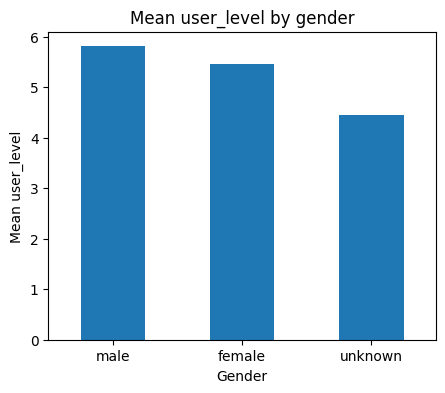


Top provinces by mean user_level:
             count  mean  median
province                       
guang dong   1029  5.89     6.0
shang hai     259  5.86     7.0
an hui        313  5.85     6.0
jiang su      602  5.83     6.0
bei jing      373  5.81     6.0
zhe jiang     498  5.77     6.0
si chuan      458  5.72     6.0
hu bei        339  5.70     6.0
fu jian       281  5.67     6.0
xin jiang     356  5.62     6.0


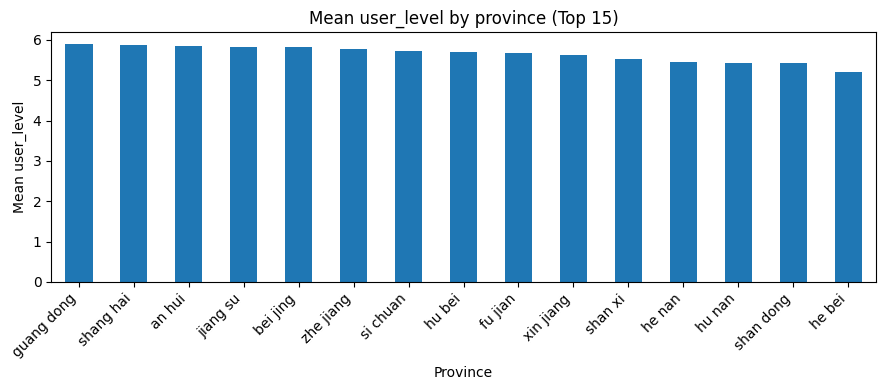

In [60]:
# Gender
if 'gender' in users.columns:
    gtab = (users.groupby('gender')['user_level']
                  .agg(['count','mean','median']).round(2)
                  .sort_values('mean', ascending=False))
    print("\nuser_level by gender:\n", gtab)

    fig = plt.figure(figsize=(5,4))
    gtab['mean'].plot(kind='bar')
    plt.title('Mean user_level by gender'); plt.ylabel('Mean user_level'); plt.xlabel('Gender')
    plt.xticks(rotation=0); plt.show()

# Province (top 15 by users)
if 'province' in users.columns:
    top_prov = users['province'].value_counts().head(15).index
    ptab = (users.loc[users['province'].isin(top_prov)]
                 .groupby('province')['user_level']
                 .agg(['count','mean','median'])
                 .sort_values('mean', ascending=False).round(2))
    print("\nTop provinces by mean user_level:\n", ptab.head(10))

    fig = plt.figure(figsize=(9,4))
    ptab['mean'].plot(kind='bar')
    plt.title('Mean user_level by province (Top 15)'); plt.ylabel('Mean user_level'); plt.xlabel('Province')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()


#### Implications

Gender differences in activity intensity are **modest**. Males average 5.81 vs females 5.46 (median 6 in both), a gap of ~0.35 on a 0–10 scale; the “Unknown” group is lower (4.45), consistent with non-random missingness. 

A Mann–Whitney test is significant with large N, but Cohen’s d indicates a small practical effect. 

We will use the columns as control/stratifier, but focus profiling on tenure (e.g. registeredMonthCnt), follow count, and early engagement—they co-move much more strongly with user_level.